In [2]:
import os
import sys
sys.path.append(os.getcwd())

from lib.models.model_execution_support import run_on_inputs_with_targets
from lib.models.recurrent_forecaster_with_correction_block import RecurrentForecasterWithCorrectionBlock
from lib.models.recurrent_sigmoid_piecewise_forecaster import RSPForecaster
from lib.models.linear_forecaster import LinearForecaster
from lib.utils.recurrent_contexts_manager import RecurrentContextsManager

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas as pd
import pandas_datareader.data as web

from typing import Any
from typing import Optional
from typing import Tuple
from uuid import uuid4
import datetime
import time

In [3]:
DEVICE = 'cpu'
DTYPE = torch.float32

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

torch.set_printoptions(precision=10)

In [4]:
df = pd.read_csv('heart_rate.csv')
print(df['T4'][890])
heart_data = np.array(df[:891]).transpose(1, 0)
heart_data = heart_data / (heart_data.max() - heart_data.min())
heart_data = heart_data - heart_data.mean()
print(heart_data)
print(heart_data.shape)

62.0
[[ 0.14598108  0.14598108  0.14204635 ...  0.4683017   0.45550151
   0.43827048]
 [ 0.28219521  0.28219521  0.27689336 ...  0.40076932  0.38879281
   0.38256881]
 [-0.30440775 -0.30440775 -0.30484894 ... -0.36155229 -0.35393276
  -0.34546305]
 [-0.32704289 -0.32704289 -0.32704289 ... -0.29516359 -0.26901976
  -0.2757001 ]]
(4, 891)


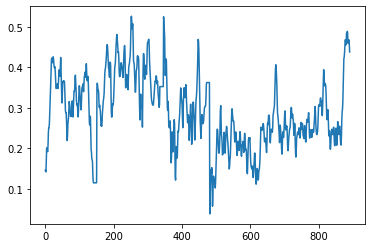

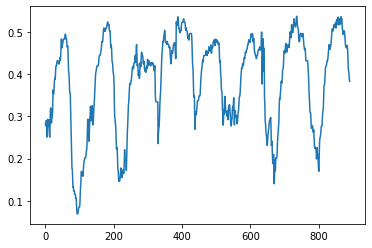

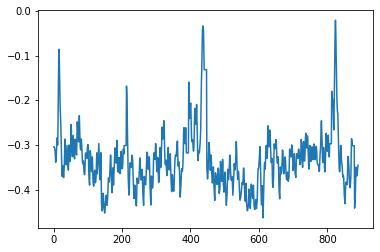

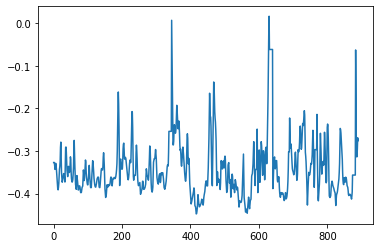

In [5]:
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[0, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[1, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[2, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[3, :])

In [6]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2021, 1, 27)

f = web.DataReader('^DJI', 'stooq', start, end)
ts = np.flip(f['Open'].values, axis=0).copy()
ts = ts / (ts.max() - ts.min())
ts = ts - ts.mean()

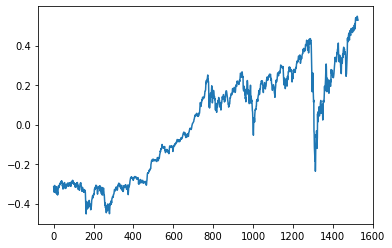

In [7]:
plt.figure()
plt.plot(range(len(ts)), ts)
plt.show()

In [8]:
print(type(ts))
print(ts.shape)
print(ts.strides)

<class 'numpy.ndarray'>
(1528,)
(8,)


In [9]:
INP_SIZE = 2

def sw(t: torch.Tensor) -> torch.Tensor:
    return t.unfold(dimension=1, size=INP_SIZE, step=1)

def get_train_test_data_heart_rate(heart_data, train_ratio=0.9):
    N = heart_data.shape[1]
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = heart_data[:, :train_size]
    test_ts = heart_data[:, train_size:]
    return (
        sw(torch.from_numpy(train_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
    )


def get_train_test_data_from_ts(ts: np.ndarray, train_ratio=0.9):
    N = len(ts)
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = ts[:train_size]
    test_ts = ts[train_size:]
    return (
        sw(torch.from_numpy(train_ts[:-1]).view(1, train_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[INP_SIZE:])[:, None, None].to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:-1]).view(1, test_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[INP_SIZE:])[:, None, None].to(DEVICE, dtype=DTYPE)
    )


inp, target, test_input, test_target = get_train_test_data_heart_rate(heart_data, train_ratio=0.8)

print(inp.shape, target.shape, test_input.shape, test_target.shape)

torch.Size([710, 4, 2]) torch.Size([710, 4, 1]) torch.Size([177, 4, 2]) torch.Size([177, 4, 1])


In [10]:
cm = RecurrentContextsManager()
baseline = LinearForecaster.find_optimal_least_squares_forecaster(cm, inp, target, bias=True)
print(baseline.predictor.weight.data)
print(baseline.predictor.bias.data)

tensor([[-0.2942165434,  1.2916926146]])
tensor([4.1599028918e-05])


torch.Size([710, 4, 1]) torch.Size([710, 4, 1])
tensor(0.0004731049, grad_fn=<MeanBackward0>)


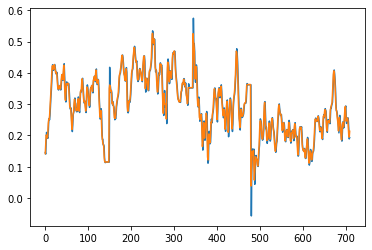

In [11]:
baseline_forecasts = run_on_inputs_with_targets(baseline, inp, target, setup_ctxs=False, delete_ctxs=False)
print(baseline_forecasts.shape, target.shape)
print(torch.square(baseline_forecasts - target).mean())
N, S, one = target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), baseline_forecasts[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
plt.show()

torch.Size([177, 4, 1]) torch.Size([177, 4, 1])
tensor(0.0004800508, grad_fn=<MeanBackward0>)


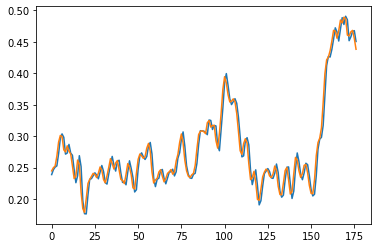

In [12]:
baseline_forecasts = run_on_inputs_with_targets(baseline, test_input, test_target,
                                                setup_ctxs=False, delete_ctxs=False)
print(baseline_forecasts.shape, test_target.shape)
print(torch.square(baseline_forecasts - test_target).mean())
N, S, one = test_target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), baseline_forecasts[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.show()

In [13]:
HIDDEN_SIZE = 8
LR = 0.08
STEPS = 50
PREV_ERRORS_NO_GRAD = True
USE_PREV_ERRORS = True

start = time.perf_counter_ns()

# INP_SIZE + 1 because correction block also takes baseline
# forecast as extra input
corrector = RSPForecaster(cm, INP_SIZE + 1, HIDDEN_SIZE, use_prev_errors=USE_PREV_ERRORS)
model = RecurrentForecasterWithCorrectionBlock(cm, baseline, corrector)

criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(model.parameters(), lr=LR)

test_losses = []
#begin to train
for i in range(STEPS):
    print('STEP: ', i)
    if isinstance(optimizer, optim.LBFGS):
        def closure():
            optimizer.zero_grad()
            baseline_no_grad = i < 15
            out = run_on_inputs_with_targets(model, inp, target, baseline_no_grad=baseline_no_grad,
                                            prev_errors_no_grad=PREV_ERRORS_NO_GRAD)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    else:
        optimizer.zero_grad()
        out = run_on_inputs_with_targets(model, inp, target, baseline_no_grad=True)
        loss = criterion(out, target)
        print('loss: ', loss.item())
        loss.backward()
        optimizer.step()
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = run_on_inputs_with_targets(model, test_input, test_target, baseline_no_grad=True)
        loss = criterion(pred, test_target)
        print('test loss:', loss.item())
        test_losses.append(loss.item())
    
end = time.perf_counter_ns()
print(f'Elapsed time: {(end - start)/1_000_000_000} seconds.')
print(f'Min test loss: {min(test_losses)}')

STEP:  0
loss: 0.15076228976249695
loss: 0.12989474833011627
loss: 0.11172860115766525
loss: 0.09415747225284576
loss: 0.07801567018032074
loss: 0.06370952725410461
loss: 0.0514189712703228
loss: 0.04116564616560936
loss: 0.03283361345529556
loss: 0.026197997853159904
loss: 0.020977875217795372
loss: 0.016891010105609894
loss: 0.013689016923308372
loss: 0.011169950477778912
loss: 0.009176607243716717
loss: 0.007589156739413738
loss: 0.006316941697150469
loss: 0.005291320383548737
loss: 0.004460065625607967
loss: 0.003783148480579257
test loss: 0.0034756639506667852
STEP:  1
loss: 0.0032296255230903625
loss: 0.0027753852773457766
loss: 0.0024014762602746487
loss: 0.0020928923040628433
loss: 0.001837651478126645
loss: 0.001626137993298471
loss: 0.0014505747240036726
loss: 0.0013046531239524484
loss: 0.0011832185555249453
loss: 0.0010820552706718445
loss: 0.0009976966539397836
loss: 0.0009272904717363417
loss: 0.0008684763452038169
loss: 0.000819308334030211
loss: 0.0007781721069477499
lo

loss: 0.0004661920538637787
loss: 0.0004661722923628986
loss: 0.00046615410246886313
loss: 0.00046613896847702563
loss: 0.0004661244456656277
loss: 0.0004661120183300227
loss: 0.00046610168647021055
test loss: 0.00046948136878199875
STEP:  14
loss: 0.00046609228593297303
loss: 0.0004660851845983416
loss: 0.0004660782578866929
loss: 0.0004660719714593142
loss: 0.00046606542309746146
loss: 0.0004660594277083874
loss: 0.0004660537524614483
loss: 0.0004660484555643052
loss: 0.0004660433332901448
loss: 0.0004660383565351367
loss: 0.00046603335067629814
loss: 0.00046602828660979867
loss: 0.00046602293150499463
loss: 0.0004660173144657165
loss: 0.00046601128997281194
loss: 0.0004660046542994678
loss: 0.0004659972619265318
loss: 0.0004659889964386821
loss: 0.00046597945038229227
loss: 0.000465968536445871
test loss: 0.0004701538709923625
STEP:  15
loss: 0.0004659557016566396
loss: 0.0004659272381104529
loss: 0.00046596763422712684
loss: 0.0004659461264964193
loss: 0.0004659203696064651
loss: 0

test loss: 0.00046257569920271635
STEP:  39
loss: 0.00045852703624404967
loss: 0.00045852677430957556
test loss: 0.0004625908040907234
STEP:  40
loss: 0.00045852677430957556
loss: 0.00045852645416744053
test loss: 0.00046261068200692534
STEP:  41
loss: 0.00045852645416744053
loss: 0.00045852636685594916
test loss: 0.00046262700925581157
STEP:  42
loss: 0.00045852636685594916
loss: 0.00045852636685594916
test loss: 0.0004626669979188591
STEP:  43
loss: 0.00045852636685594916
loss: 0.00045852645416744053
test loss: 0.0004626989830285311
STEP:  44
loss: 0.00045852645416744053
loss: 0.00045852645416744053
test loss: 0.00046273181214928627
STEP:  45
loss: 0.00045852645416744053
loss: 0.00045852569746784866
test loss: 0.0004627584130503237
STEP:  46
loss: 0.00045852569746784866
loss: 0.00045852476614527404
test loss: 0.00046279208618216217
STEP:  47
loss: 0.00045852476614527404
loss: 0.0004585236601997167
loss: 0.0004585223214235157
loss: 0.0004585206916090101
loss: 0.00045851871254853904
lo

In [14]:
print(baseline.predictor.weight.data)
print(baseline.predictor.bias.data)

tensor([[-0.2785312235,  1.4279309511]])
tensor([0.0555527806])


torch.Size([710, 4, 1]) torch.Size([710, 4, 1])
tensor(0.0004573940)


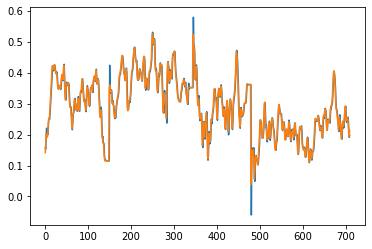

In [15]:
with torch.no_grad():
    model_forecasts = run_on_inputs_with_targets(model, inp, target, setup_ctxs=True, delete_ctxs=True)
    print(model_forecasts.shape, target.shape)
    print(torch.square(model_forecasts - target).mean())
    N, S, one = target.shape
    SEQ_IDX = 0
    plt.figure()
    plt.plot(np.arange(N), model_forecasts[:, SEQ_IDX, :].detach())
    plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
    plt.show()

torch.Size([177, 4, 1]) torch.Size([177, 4, 1])
tensor(0.0004678139)


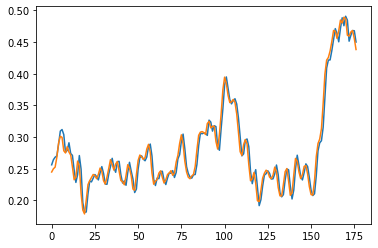

In [16]:
with torch.no_grad():
    model_forecasts = run_on_inputs_with_targets(model, test_input, test_target,
                                                 setup_ctxs=True, delete_ctxs=True)
    print(model_forecasts.shape, test_target.shape)
    print(torch.square(model_forecasts - test_target).mean())
    N, S, one = test_target.shape
    SEQ_IDX = 0
    plt.figure()
    plt.plot(np.arange(N), model_forecasts[:, SEQ_IDX, :].detach())
    plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
    plt.show()

In [16]:
print('''
loss: 0.00044439133489504457
test loss: 0.0004625237488653511
Elapsed time: 263.367878655 seconds.
Min test loss: 0.00046113631105981767
''')


loss: 0.00044439133489504457
test loss: 0.0004625237488653511
Elapsed time: 263.367878655 seconds.
Min test loss: 0.00046113631105981767



In [14]:
print(test_target.shape)

torch.Size([4, 88])


In [44]:
'RSP test loss: 0.0006836527948247121'

'RSP test loss: 0.0006836527948247121'

In [46]:
'Linear test loss: 0.00068016676907737'

'Linear test loss: 0.00068016676907737'